### Suppose we select N genes and use their counts to make a case-ctrl prediction via logistic regression. Is the prediction accuracy higher if the genes are on the same pathway?
Mira Welner

May 1

### Step 1: Import Libraries and set random seed

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import requests
np.random.seed(42)
from sklearn.linear_model import LogisticRegression

### Step 2: Load metadata to create ground truth
First we load the raw metadata file, `pe-rna-metadata.csv` which maps the samples to the classification

In [2]:
raw_meta = pd.read_csv('gene_data/pe-rna-metadata.csv',header=None, names=["sample", "classification"]).T
raw_meta

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
sample,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
classification,Control,Mild,Mild,Mild,Control,Control,Severe,Mild,Control,Severe,...,Mild,Severe,Severe,Severe,Severe,Severe,Mild,Mild,Mild,Severe


Then we turn the sample row into the columns because it is easier to work with later

In [3]:
catagorical_ground_truth  = pd.DataFrame(raw_meta.values[1:], columns=raw_meta.iloc[0])
catagorical_ground_truth.columns.name = None
catagorical_ground_truth

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
0,Control,Mild,Mild,Mild,Control,Control,Severe,Mild,Control,Severe,...,Mild,Severe,Severe,Severe,Severe,Severe,Mild,Mild,Mild,Severe


But this particular logistic regression is case-ctrl, while the above is catagorical. So then we need to change it into case vs control

In [4]:
ground_truth = [{"Control": "ctrl", "Severe": "case", "Mild": "case"}.get(item, item) for item in list(catagorical_ground_truth.loc[0])]
print(ground_truth)

['ctrl', 'case', 'case', 'case', 'ctrl', 'ctrl', 'case', 'case', 'ctrl', 'case', 'case', 'ctrl', 'ctrl', 'ctrl', 'case', 'ctrl', 'case', 'ctrl', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case']


### Step 3: Load and process counts
First we load the raw counts file, `pe-rna-counts.csv` and run it through `np.log1p` to take the logs of the counts+1

In [5]:
unfiltered_counts = np.log1p(pd.read_csv('gene_data/pe-rna-counts.csv', index_col=0))
unfiltered_counts

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
ENSG00000000419,3.583519,5.303305,7.074963,6.028279,0.000000,6.946976,4.499810,6.747587,0.000000,5.966147,...,7.100028,6.905753,7.099202,5.537334,0.000000,5.910797,6.429719,6.931472,6.118097,0.000000
ENSG00000000457,6.001415,0.000000,3.931826,6.336826,5.720312,5.774552,6.373320,6.146329,0.000000,4.787492,...,6.309918,7.311218,7.907652,6.418365,6.255750,2.302585,6.251904,6.502790,5.308268,5.902633
ENSG00000000460,5.652489,0.000000,5.934894,0.000000,4.795791,0.000000,5.036953,0.000000,0.000000,0.000000,...,7.098376,6.505784,0.000000,4.795791,0.000000,5.493061,6.322565,6.006353,4.189655,0.000000
ENSG00000000938,7.959975,7.421178,8.806424,8.457868,8.099251,7.702556,8.263075,8.235891,8.310169,8.835647,...,9.149209,10.213322,8.968778,7.729296,8.234830,7.521318,8.253227,9.376024,8.475954,8.511980
ENSG00000000971,0.000000,3.044522,6.502790,4.434251,0.000000,0.000000,0.000000,5.288267,0.000000,6.871091,...,0.000000,5.855072,5.288267,3.663562,0.000000,4.007333,0.000000,5.326978,0.000000,4.127134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000293497,0.000000,2.995732,6.553935,4.477337,0.000000,0.000000,3.713572,0.000000,0.000000,4.574711,...,2.639057,6.046547,0.000000,3.555348,5.955837,0.000000,5.723585,6.408527,4.852030,0.000000
ENSG00000293508,0.000000,0.693147,5.153292,5.613128,0.000000,0.000000,5.159055,0.000000,0.000000,5.723585,...,1.609438,0.000000,2.079442,0.000000,4.418841,5.857933,5.811141,5.117994,0.000000,2.197225
ENSG00000293510,5.303305,5.533389,0.000000,4.804021,6.575076,0.000000,6.304449,2.397895,0.000000,4.584967,...,0.000000,6.425222,5.868463,0.000000,4.418841,4.025352,7.156956,7.134547,5.902633,4.110874
ENSG00000293514,5.313206,5.283204,6.011267,5.252273,0.000000,0.000000,6.857514,5.666427,0.000000,0.000000,...,0.000000,6.527958,5.786897,5.509388,0.000000,4.948760,0.000000,5.308268,6.575076,6.981006


Then we want the ensembl codes which correspond to the genes that I identified in the papers regarding preeclamptia. To do this we load the `genes.csv` file which I manually created which maps the standard nomenclature (for example, IGF2) with the ensembl code (for example, ENSG00000167244). The variable `codes` represents the ensembl codes corresponding to genes that I identified which are also found in our database

In [6]:
codes = [g for g in list(pd.read_csv('gene_data/genes.csv')["code"]) if g in unfiltered_counts.index]
codes

['ENSG00000213741',
 'ENSG00000156508',
 'ENSG00000167244',
 'ENSG00000150991',
 'ENSG00000149806',
 'ENSG00000087086',
 'ENSG00000034510',
 'ENSG00000172379',
 'ENSG00000278637',
 'ENSG00000113761',
 'ENSG00000159388',
 'ENSG00000122641',
 'ENSG00000265681',
 'ENSG00000125691',
 'ENSG00000161970',
 'ENSG00000131469',
 'ENSG00000071082',
 'ENSG00000109475',
 'ENSG00000143977',
 'ENSG00000181163',
 'ENSG00000114942',
 'ENSG00000173372',
 'ENSG00000173369',
 'ENSG00000155659',
 'ENSG00000102755',
 'ENSG00000119630',
 'ENSG00000120278',
 'ENSG00000130600',
 'ENSG00000084207',
 'ENSG00000143819',
 'ENSG00000120915',
 'ENSG00000017427',
 'ENSG00000077238',
 'ENSG00000197081',
 'ENSG00000184371',
 'ENSG00000113296',
 'ENSG00000115956',
 'ENSG00000174697',
 'ENSG00000130600',
 'ENSG00000115414',
 'ENSG00000176014',
 'ENSG00000187474',
 'ENSG00000137496',
 'ENSG00000164307',
 'ENSG00000164308',
 'ENSG00000134107',
 'ENSG00000070404',
 'ENSG00000159399',
 'ENSG00000174697',
 'ENSG00000111961',


It's also helpful to have dictionaries which can swap back and forth between the ensemble code and the standard nomenclature

In [7]:
to_name = pd.read_csv('gene_data/genes.csv').set_index("code")["name"].to_dict()
to_ensembl = pd.read_csv('gene_data/genes.csv').set_index("name")["code"].to_dict()

Then we want to filter the counts to only have genes that I identified as being associated with preeclamptia

In [8]:
counts = unfiltered_counts.loc[list(set(codes))]
counts

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
ENSG00000071082,9.080232,8.372630,10.270558,10.218554,9.234643,8.806424,9.831777,9.154616,7.555382,9.017483,...,10.051951,10.328363,9.942612,9.664850,8.899185,8.479907,9.664405,10.385265,9.562405,9.627866
ENSG00000159399,0.000000,6.056784,6.558198,5.697093,0.000000,6.120297,6.426488,6.396930,6.354370,5.575949,...,8.346405,8.584104,7.331715,6.023448,6.270988,5.880533,7.294377,6.580639,6.327937,5.075174
ENSG00000105497,6.617403,5.062595,4.394449,6.045005,0.000000,6.434547,5.501258,3.496508,4.804021,5.117994,...,3.931826,6.563856,6.731018,5.135798,4.919981,5.616771,0.000000,5.587249,0.000000,4.990433
ENSG00000106366,7.262629,4.844187,5.686975,5.049856,0.000000,6.536692,6.216606,4.927254,5.961005,3.258097,...,5.955837,7.351158,6.461468,6.113682,4.605170,3.044522,6.259581,0.000000,4.828314,5.693732
ENSG00000172379,0.000000,0.000000,5.017280,4.077537,0.000000,0.000000,0.000000,0.000000,6.163315,0.693147,...,0.000000,0.000000,6.519147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000184371,1.609438,5.010635,4.356709,0.000000,6.608001,8.529714,3.496508,0.000000,5.746203,6.741701,...,3.637586,2.484907,6.505784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000181163,9.253490,8.694816,10.113816,9.925554,9.487214,8.496582,9.954592,9.329082,8.807257,9.748074,...,10.113765,10.418584,10.189281,10.133855,8.837832,8.919144,9.881820,10.576344,9.624714,9.800490
ENSG00000170542,7.314553,6.228511,7.145984,7.556951,8.012018,7.229839,6.924612,6.184149,8.172447,7.561122,...,8.023552,8.573952,7.509335,7.085064,6.428105,6.350886,6.747587,7.753194,7.032624,6.959399
ENSG00000120278,7.814400,6.086775,7.077498,7.552237,8.144389,0.000000,6.762730,6.692084,6.709304,6.786717,...,6.464588,7.292337,7.844633,6.484635,6.421622,4.248495,5.438079,8.132413,7.131699,7.047517


It is also useful to have a list identical to codes but with the standard nomenclature rather than the ensembl code

In [9]:
genes = list(set([to_name[x] for x in codes]))

### Step 4: Create the two dictionaries
The dictionary gene_to_pathway queries pathwaycommons and gets every pathway associated with that gene. The keys are genes and the values are lists of corresponding pathways

In [10]:
gene_to_pathway = {}
for g in tqdm(genes):
    gene_to_pathway[g] = re.findall(
        r'"name":"(.*?)","dataSource":',
        requests.get(
            "https://www.pathwaycommons.org/pc2/top_pathways?q=" + g
        ).text,
    )
gene_to_pathway

  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 73/73 [00:08<00:00,  8.88it/s]


{'IGF2': ['Posttranslational regulation of adherens junction stability and dissassembly',
  'Heterotrimeric GPCR signaling pathway (through G alpha i and pertussis toxin) ( GPCR signaling (pertussis toxin) )',
  'Heterotrimeric GPCR signaling pathway (through_G alpha s_ACs_PKA_BRaf_and_ERKcascade)(canonical) ( GPCR signaling (G alpha s, PKA and ERK) )',
  'Insulin/IGF pathway-protein kinase B signaling cascade',
  'Insulin/IGF pathway-mitogen activated protein kinase kinase/MAP kinase cascade',
  'Heterotrimeric GTP-binding protein coupled receptor signaling pathway (through G alpha i, adenylate cyclase and cAMP) ( GPCR signaling (G alpha i) )',
  'Heterotrimeric GPCR signaling pathway (through G alpha s ACs Epac BRaf and ERKcascade) ( GPCR signaling (G alpha s, Epac and ERK) )',
  'Heterotrimeric GPCR signaling pathway (through G alpha q, PLC beta and ERK cascade) ( GPCR signaling (G alpha q) )',
  'Heterotrimeric GTP-binding protein coupled receptor signaling pathway (through_G_alpha

But we also need a flipped version of this, pathways_to_genes which maps the other way around

In [11]:
pathways_to_genes = defaultdict(list)
for gene, pathways in gene_to_pathway.items():
    for pathway in pathways:
        pathways_to_genes[pathway].append(gene)
pathways_to_genes = dict(pathways_to_genes)
pathways_to_genes

{'Posttranslational regulation of adherens junction stability and dissassembly': ['IGF2'],
 'Heterotrimeric GPCR signaling pathway (through G alpha i and pertussis toxin) ( GPCR signaling (pertussis toxin) )': ['IGF2',
  'LEP',
  'VEGFB',
  'IGF1',
  'VEGFC',
  'VEGFA',
  'TNF',
  'INHBA'],
 'Heterotrimeric GPCR signaling pathway (through_G alpha s_ACs_PKA_BRaf_and_ERKcascade)(canonical) ( GPCR signaling (G alpha s, PKA and ERK) )': ['IGF2',
  'LEP',
  'VEGFB',
  'IGF1',
  'VEGFC',
  'VEGFA',
  'TNF',
  'INHBA'],
 'Insulin/IGF pathway-protein kinase B signaling cascade': ['IGF2',
  'IGF2R',
  'IGF1'],
 'Insulin/IGF pathway-mitogen activated protein kinase kinase/MAP kinase cascade': ['IGF2',
  'IGF2R',
  'IGF1'],
 'Heterotrimeric GTP-binding protein coupled receptor signaling pathway (through G alpha i, adenylate cyclase and cAMP) ( GPCR signaling (G alpha i) )': ['IGF2',
  'LEP',
  'VEGFB',
  'IGF1',
  'VEGFC',
  'VEGFA',
  'TNF',
  'INHBA'],
 'Heterotrimeric GPCR signaling pathway (t

### Step 5: Create samples of genes

We then query the list of pathways_with_min_5_genes to get a test set, which is five genes that all share a pathway, and a traning set which is five different genes all sharing a pathway. The test set and training set must have no overlap because this will cause overfitting

In [12]:
def get_pathway_genes(N):
    pathways_with_min_N_genes = [pathway for pathway, genes in pathways_to_genes.items() if len(genes)>N]

    train_pathway_genes = np.random.choice(pathways_to_genes[np.random.choice(pathways_with_min_N_genes)], size=N, replace=False).tolist()
    while True:
        test_pathway_genes = np.random.choice(pathways_to_genes[np.random.choice(pathways_with_min_N_genes)], size=N, replace=False).tolist()
        if not set(train_pathway_genes).intersection(test_pathway_genes):
            break

    return train_pathway_genes, test_pathway_genes
train_pathway_genes, test_pathway_genes = get_pathway_genes(5)
train_pathway_genes, test_pathway_genes

(['NDRG1', 'LEP', 'VEGFA', 'BHLHE40', 'HK2'],
 ['RPL26', 'RPL27', 'RPS29', 'RPL17', 'RPL23'])

Then we get 5 random genes

In [13]:
def get_random_genes(N):
    train_random_genes = np.random.choice(genes,size=N, replace=False).tolist()
    test_random_genes = np.random.choice([g for g in genes if g not in train_random_genes],size=N, replace=False).tolist()
    return train_random_genes, test_random_genes
train_random_genes, test_random_genes = get_random_genes(5)
train_random_genes, test_random_genes 

(['ERAP2', 'IGF2', 'RPL31', 'RPL17', 'IGF2R'],
 ['MYO7B', 'PLEK', 'SASH1', 'EEF1A1', 'RPL34'])

Now note that this is N RANDOM genes, not N genes all in N different pathways. There may be genes that share a pathway, there may not be. The reason for this is, there are a lot of genes that share a lot of pathways. For example LYN is on 38 different pathways and EPHX2 is on 43 pathways (there are 326 total pathways represented in the dataset). So if all genes were ensured to be on different pathways that meant that either:
1) Some genes in the train will also be in the test, which causes overfitting
2) There is one or maybe two genes that have a ton of pathways like LYN and then a bunch of genes that are on very few pathways. It is possible that genes on many pathways are better or worse indicators, so this in itself would be its own type of filtering which would screw up the results

I didn't want either of these situations so I simply chose random genes

### Step 6: Load counts based on genes

Then we load the counts which corespond to our selected test and training sets.

In [14]:
def train_test_counts(train_genes, test_genes):
    train_counts = counts.loc[[to_ensembl[k] for k in train_genes], :]
    train_counts.reset_index(drop=True, inplace=True)
    test_counts = counts.loc[[to_ensembl[k] for k in test_genes], :]
    test_counts.reset_index(drop=True, inplace=True)
    return train_counts, test_counts

In [15]:
train_pathway_counts, test_pathway_counts = train_test_counts(train_pathway_genes, test_pathway_genes)
train_random_counts, test_random_counts = train_test_counts(train_random_genes, test_random_genes)

Here is an example of what the dataframes should look like:

In [16]:
train_pathway_counts

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
0,7.865955,7.081708,7.368180,7.112548,7.589336,7.911691,7.646831,7.443078,8.034955,7.862206,...,7.766841,8.404472,8.659040,7.445418,6.132046,6.606954,6.904751,8.489443,7.312776,7.591357
1,6.716595,3.931826,5.379897,0.000000,0.000000,0.000000,0.000000,5.545177,5.690359,4.356709,...,0.000000,0.000000,8.494334,4.382027,3.091042,6.246107,4.812184,6.717805,6.082219,0.000000
2,0.000000,6.257668,0.000000,5.192957,5.993961,0.000000,0.000000,5.802118,0.000000,6.276643,...,6.352629,7.633854,0.000000,5.347108,4.709530,6.272877,5.723585,5.652489,4.744932,5.402677
3,7.264030,6.997596,8.023552,7.855157,7.337588,6.727432,6.839476,7.078342,6.095825,7.387709,...,7.228388,7.956477,8.768885,6.708084,7.192181,5.866468,7.543803,8.359135,7.852828,6.042633
4,0.000000,6.056784,6.558198,5.697093,0.000000,6.120297,6.426488,6.396930,6.354370,5.575949,...,8.346405,8.584104,7.331715,6.023448,6.270988,5.880533,7.294377,6.580639,6.327937,5.075174


### Step 6: Logistic regression

Then we create a logistic regression model, fit it to the train counts and test it on the test counts

In [17]:
def model_accuracy(train_counts, test_counts, random_state=None):
    clf = LogisticRegression(random_state=random_state).fit(train_counts.T, ground_truth)
    y_pred = clf.predict(test_counts.T)
    accuracy = y_pred==ground_truth
    return sum(accuracy)/len(accuracy)

We train and test of on the two different sets of genes which all share pathways

In [18]:
model_accuracy(train_pathway_counts, test_pathway_counts, random_state=0)

0.7567567567567568

In [19]:
model_accuracy(train_random_counts, test_random_counts, random_state=0)

0.24324324324324326

Well this looks promising. Lets run do some more comprehensive testing

The following function is just the above code except there is a variable `itt` which is the iterations that the logistic regression model is run. So rather than getting one random gene accuracy and one accuracy for genes on the same pathway, you get `itt` accuracies and can take the mean.

Also, rather than 5 genes, it tests the values for `N` genes

In [20]:
def logistic_path_vs_nonpath(N, itt):
    random_gene_accuracy = []
    same_pathway_accuracy = []

    for _ in range(itt):
        train_pathway_genes, test_pathway_genes = get_pathway_genes(N)
        train_random_genes, test_random_genes = get_random_genes(N)

        train_pathway_counts, test_pathway_counts = train_test_counts(train_pathway_genes, test_pathway_genes)
        train_random_counts, test_random_counts = train_test_counts(train_random_genes, test_random_genes)

        same_pathway_accuracy.append(model_accuracy(train_pathway_counts, test_pathway_counts))
        random_gene_accuracy.append(model_accuracy(train_random_counts, test_random_counts))

    return same_pathway_accuracy, random_gene_accuracy


This runs the above function for 30 iterations to get a good sample of accuracies. It runs it from N=2 (2 genes per regression) to N=5 (5 genes per regression) and plots it

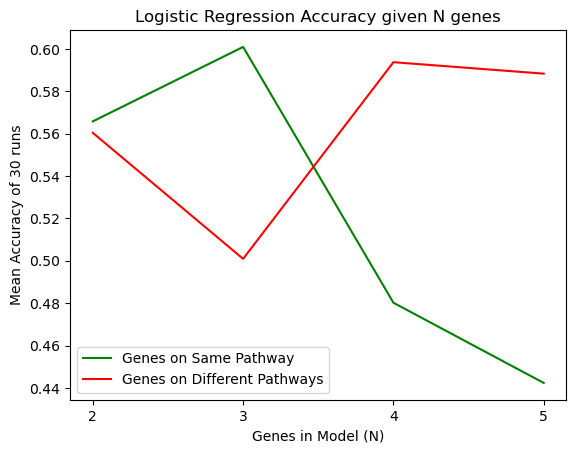

In [21]:
x = list(range(2,6))
s, d = [], []
itt = 30
for n in x:
    same, diff = logistic_path_vs_nonpath(n, itt)
    s.append(np.mean(same))
    d.append(np.mean(diff))
plt.plot(x, s, color='green', label='Genes on Same Pathway')
plt.plot(x, d, color='red', label="Genes on Different Pathways")
plt.xticks(x)
plt.ylabel(f"Mean Accuracy of {itt} runs")
plt.xlabel("Genes in Model (N)")
plt.title("Logistic Regression Accuracy given N genes")
plt.legend()
plt.show()

This is not particularly promising